## $\textrm{Import libraries}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, Input, layers, losses, metrics
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras import regularizers, initializers
from tensorflow.keras import backend as K

print(tf.__version__)

import time
import random

2.14.0


## $\textrm{Loading full data set}$

In [2]:
data = pd.read_csv('bank_additional_full.csv',sep=';')
print("Shape of the full data set: ", data.shape)

Shape of the full data set:  (41188, 21)


In [3]:
# check how many columns are numeric and how many are categorical
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
# checking for any null value
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## $\textrm{Separate input and target as well as drop `duration' column}$

In [5]:
# separate input and target (i.e., last column)
X = data.drop(columns=['y','duration']) # drop the last column (target) and 'duration' column
Y = data['y'].map({'yes': 1.0, 'no': 0.0})  # Convert target to binary
print("Shape of the input data: ", X.shape)
print("Shape of traget: ", Y.shape)

Shape of the input data:  (41188, 19)
Shape of traget:  (41188,)


In [6]:
# print the input data
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6


In [7]:
# print target data
Y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41183    1.0
41184    0.0
41185    0.0
41186    1.0
41187    0.0
Name: y, Length: 41188, dtype: float64

## $\textrm{Numerical and categorical input data}$

In [8]:
# separate the numeric and categorical input data
X_num = X.select_dtypes(['int64',"float64"]) # numeric input data
X_obj = X.select_dtypes('object') # categorical input data
print('Shape of the numeric input data: ', X_num.shape)
print('Shape of the categorical input data: ', X_obj.shape)

Shape of the numeric input data:  (41188, 9)
Shape of the categorical input data:  (41188, 10)


In [9]:
# frequency of 'unknown' entry in each categorical column
for col in X_obj.columns:
    count = (X_obj[col] == 'unknown').sum()  # Count the occurrences of 'unknown'
    print(f"Column '{col}' has {count} 'unknown' entries.")

Column 'job' has 330 'unknown' entries.
Column 'marital' has 80 'unknown' entries.
Column 'education' has 1731 'unknown' entries.
Column 'default' has 8597 'unknown' entries.
Column 'housing' has 990 'unknown' entries.
Column 'loan' has 990 'unknown' entries.
Column 'contact' has 0 'unknown' entries.
Column 'month' has 0 'unknown' entries.
Column 'day_of_week' has 0 'unknown' entries.
Column 'poutcome' has 0 'unknown' entries.


## $\textrm{Visualization of data}$

#### $\textrm{For categorical data}$

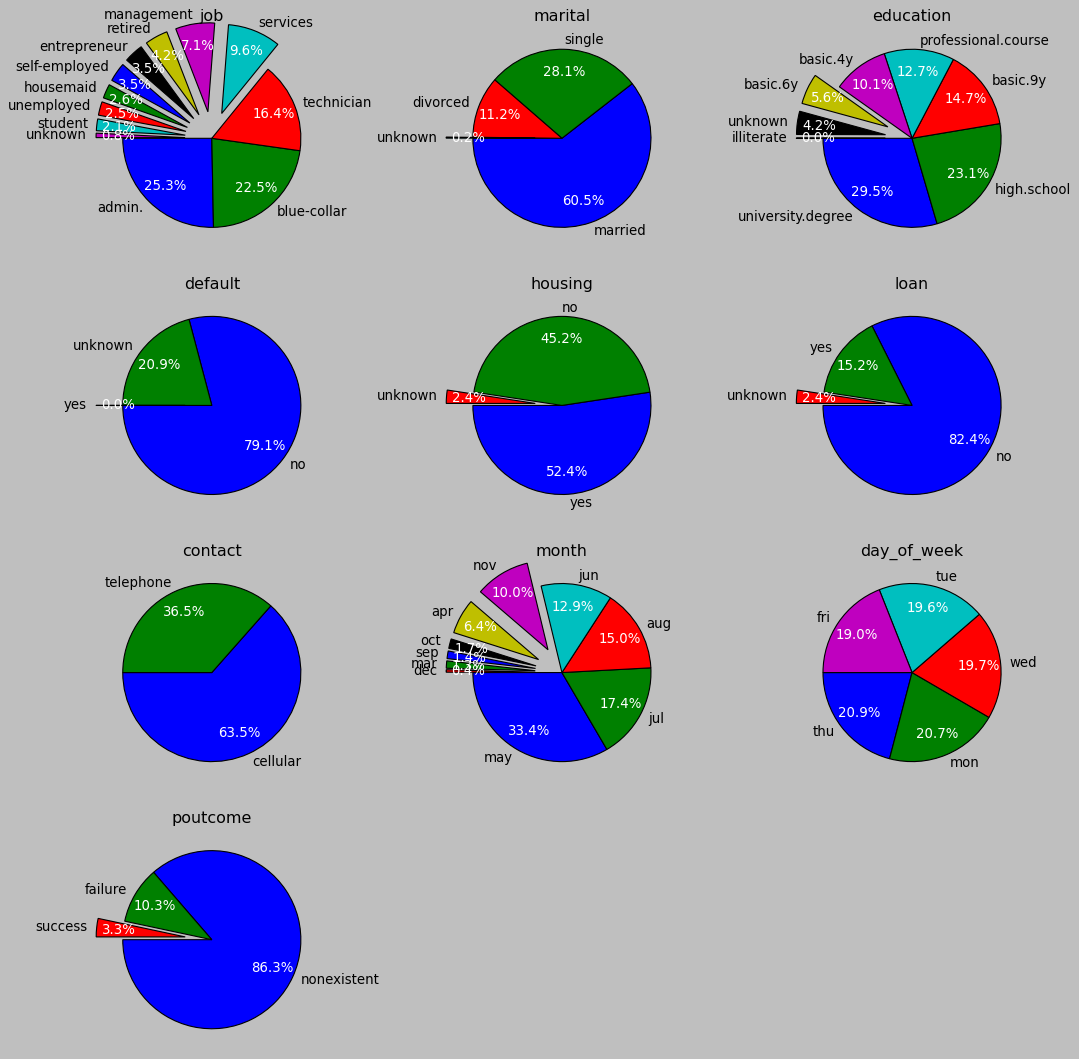

In [10]:
%matplotlib inline
plt.style.use('classic')

# Set up subplots (2 rows and 5 columns)
fig, axs = plt.subplots(4, 3, figsize=(16,16))

# Flatten axs for easy iteration
axs = axs.flatten()

# Loop through each column and create a pie chart
for i, col in enumerate(X_obj.columns):
    # Get value counts for each column
    value_counts = X_obj[col].value_counts()
    # Determine threshold for narrow slices (e.g., less than 10% of total)
    threshold = 0.1 * value_counts.sum()
    
    # Create an explode list to offset narrow slices
    explode = [0.3 if value < threshold else 0 for value in value_counts]  # Explode narrow slices
    
    # Plot pie chart for each column
    axs[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=180,
               textprops={'color': 'k'}, explode=explode, pctdistance=0.75)
    axs[i].set_title(f'{col}')
    # Customize the percentage text color to white
    for text in axs[i].texts:
        if text.get_text().endswith('%'):
            text.set_color('white')  # Set percentage text color to white

# Hide the last two subplots
for j in range(len(X_obj.columns), len(axs)):
    axs[j].axis('off')  # Hide the axis of the unused subplots

# save the figure
plt.savefig('Pie_chart_object.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

#### $\textrm{For numerical data}$

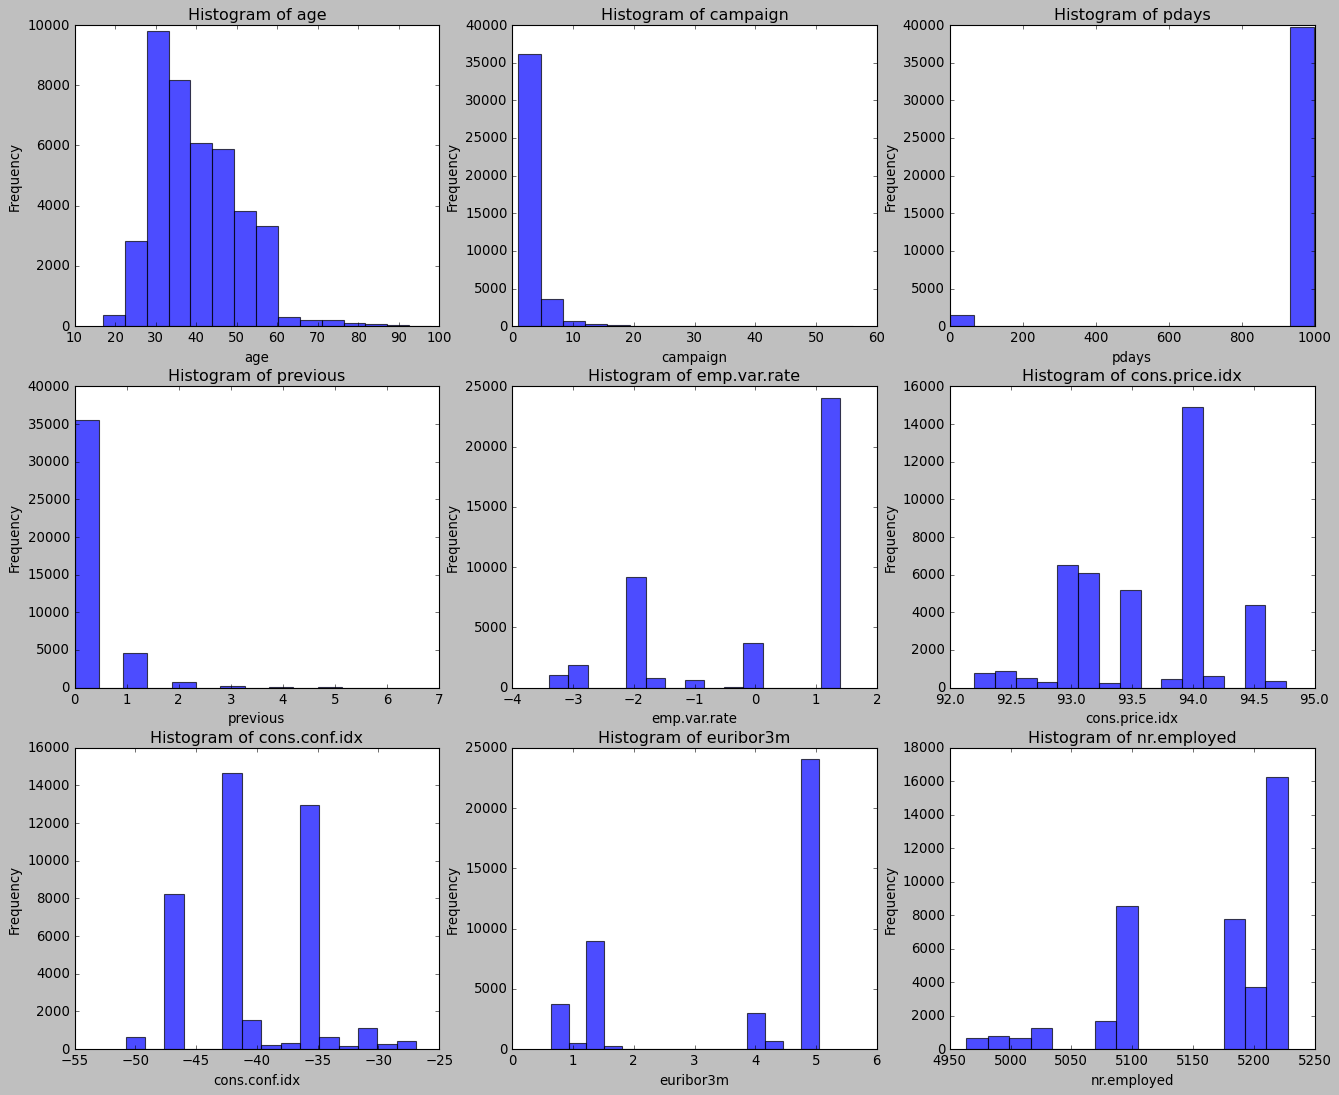

In [11]:
%matplotlib inline
plt.style.use('classic')

# Set up subplots (e.g., 2 rows and 2 columns for 4 histograms)
nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 16))

# Flatten axs for easy iteration
axs = axs.flatten()

# Loop through each numeric column and create a histogram
for i, col in enumerate(X_num.columns):
    axs[i].hist(X_num[col], bins=15, color='blue', alpha=0.7, edgecolor='black')
    axs[i].set_title(f'Histogram of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

# Hide the last two subplots
for j in range(len(X_num.columns), len(axs)):
    axs[j].axis('off')  # Hide the axis of the unused subplots

# save the figure
plt.savefig('Histogram_numerical.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

#### $\textrm{Correlations between numerical columns}$

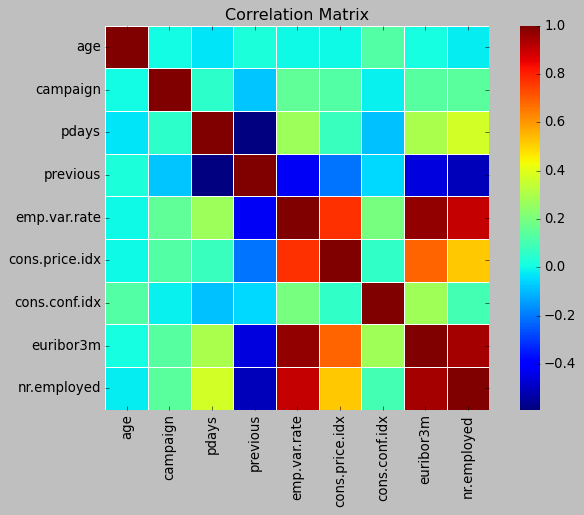

In [12]:
# Calculate the correlation matrix
correlation_matrix = X_num.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='jet', square=True, 
            cbar_kws={'shrink': 1}, linewidths=0.5)

# Set titles and labels
plt.title('Correlation Matrix')

# save the figure
plt.savefig('Corr_numerical.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

In [13]:
correlation_matrix

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
campaign,0.004594,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


## $\textrm{Artificial Neural Network (ANN) method}$

#### $\textrm{Split data into training, validation and test sets}$

In [14]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.1, random_state=40)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, random_state=40)

print('Shape of training input: ', X_train.shape)
print('Shape of training traget', Y_train.shape)
print('\n')
print('Shape of validation input: ', X_val.shape)
print('Shape of validation traget', Y_val.shape)
print('\n')
print('Shape of test input: ', X_test.shape)
print('Shape of test traget', Y_test.shape)

Shape of training input:  (37069, 19)
Shape of training traget (37069,)


Shape of validation input:  (2059, 19)
Shape of validation traget (2059,)


Shape of test input:  (2060, 19)
Shape of test traget (2060,)


#### $\textrm{Data preprocessing}$

In [15]:
# Build the ColumnTransformer, 'num' and 'obj' are labelled name for transformer
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), X_num.columns),
                                               ('obj', OneHotEncoder(drop='first',sparse_output=False),
                                                 X_obj.columns)])

# Fit and transform training data
X_train_prime = preprocessor.fit_transform(X_train)

# Transform validation and test data
X_val_prime = preprocessor.transform(X_val)
X_test_prime = preprocessor.transform(X_test)

# columns number increases due to the transformation of multiple unique values...
# of each categorical column into multiple columns
print('Shape of training input after preprocessing', X_train_prime.shape)
print('Shape of validation input after preprocessing', X_val_prime.shape)
print('Shape of test input after preprocessing', X_test_prime.shape)

Shape of training input after preprocessing (37069, 52)
Shape of validation input after preprocessing (2059, 52)
Shape of test input after preprocessing (2060, 52)


#### $\textrm{Custom loss}$

In [16]:
def combined_bfc_kld_loss(alpha, beta):
    def loss(y_true, y_pred):
        bfc = tf.keras.losses.binary_focal_crossentropy(y_true, y_pred)
        kld = tf.keras.losses.KLD(y_true, y_pred) # KlDivergence loss
        return alpha*bfc + beta*kld
    return loss

#### $\textrm{Define ANN model}$

In [17]:
def create_model(n): # n is number neurons in hidden layer
    inp = Input(shape=(52,))
    x = Dense(n, activation='silu',kernel_regularizer=regularizers.L2())(inp)
    out = Dense(1 ,activation='sigmoid')(x)

    # build the model
    model = Model(inp,out)
    
    # comile the model
    model.compile(optimizer=Nadam(1e-4),
                  loss = combined_bfc_kld_loss(0.5,0.5),
                  metrics=['accuracy',metrics.Precision(name='precision',thresholds=0.5),
                           metrics.Recall(name='recall',thresholds=0.5),
                           metrics.F1Score(threshold=0.5)])

    return model

In [18]:
# summary of the ANN model
model = create_model(25) # taking n =25
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense (Dense)               (None, 25)                1325      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1351 (5.28 KB)
Trainable params: 1351 (5.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### $\textrm{Model training}$

In [19]:
kat = time.time()
# setting the seed value for a fixed random initialization of weights
seed_value = 100
random.seed(seed_value)
np.random.seed(seed_value+1)
tf.random.set_seed(seed_value+2)

model = create_model(25)

# storing the training history for training and validation sets
history = model.fit(x=X_train_prime,y=Y_train,batch_size=128,epochs=100,validation_data=(X_val_prime,Y_val))

kit = time.time()
print((kit-kat)/60,'min')

Epoch 1/100
290/290 [==============================] - 4s 5ms/step - loss: 0.4359 - accuracy: 0.6488 - precision: 0.1464 - recall: 0.4431 - f1_score: 0.2201 - val_loss: 0.3840 - val_accuracy: 0.8091 - val_precision: 0.2727 - val_recall: 0.3704 - val_f1_score: 0.3141
Epoch 2/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3388 - accuracy: 0.8507 - precision: 0.3311 - recall: 0.3283 - f1_score: 0.3297 - val_loss: 0.3058 - val_accuracy: 0.8640 - val_precision: 0.4098 - val_recall: 0.3457 - val_f1_score: 0.3750
Epoch 3/100
290/290 [==============================] - 1s 4ms/step - loss: 0.2731 - accuracy: 0.8778 - precision: 0.4376 - recall: 0.3247 - f1_score: 0.3727 - val_loss: 0.2493 - val_accuracy: 0.8800 - val_precision: 0.4886 - val_recall: 0.3539 - val_f1_score: 0.4105
Epoch 4/100
290/290 [==============================] - 1s 4ms/step - loss: 0.2244 - accuracy: 0.8856 - precision: 0.4839 - recall: 0.3435 - f1_score: 0.4017 - val_loss: 0.2070 - val_accuracy: 0.8859 

#### $\textrm{Save the model and history}$

In [20]:
# save model to file
model.save('ANNmodel.h5')
# save the history in numpy file
np.save('ModelHistory.npy',history.history)

/home/srikanta/anaconda3/envs/TensorFlow/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### $\textrm{Load the model and history}$

In [22]:
# load model with defining custom loss
model = keras.saving.load_model('ANNmodel.h5',custom_objects={'loss': combined_bfc_kld_loss(0.5,0.5)})

# load history
history = np.load('ModelHistory.npy', allow_pickle=True).item()
print(history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


#### $\textrm{Loss function, accuracy, precision, recall and f1Score}$

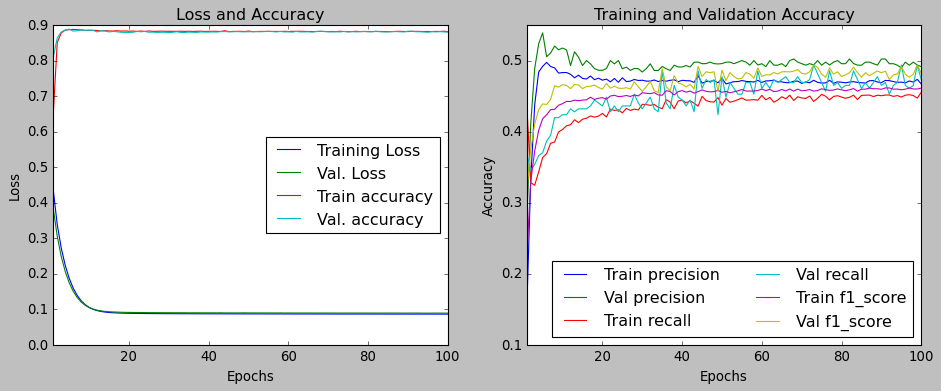

In [30]:
%matplotlib inline
plt.style.use('classic')

# Extract the loss and accuracy values
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

precision = history['precision']
val_precision = history['val_precision']

recall = history['recall']
val_recall = history['val_recall']

f1_score = history['f1_score']
val_f1_score = history['val_f1_score']

# Get the number of epochs
epochs = range(1, len(loss) + 1)

# Plot model loss
plt.figure(figsize=(14, 5))

# Plotting loss
plt.subplot(1, 2, 1)
#plt.grid(ls='-',alpha=0.25)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Val. Loss')
plt.plot(epochs, accuracy, label='Train accuracy')
plt.plot(epochs, val_accuracy, label='Val. accuracy')
plt.title('Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1,100)
plt.legend(loc='center right')

# Plotting accuracy
plt.subplot(1, 2, 2)
#plt.grid(ls='-',alpha=0.25)
plt.plot(epochs, precision, label='Train precision')
plt.plot(epochs, val_precision, label='Val precision')
plt.plot(epochs, recall, label='Train recall')
plt.plot(epochs, val_recall, label='Val recall')
plt.plot(epochs, f1_score, label='Train f1_score')
plt.plot(epochs, val_f1_score, label='Val f1_score')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(1,100)
plt.legend(loc='lower right',ncols=2)

# save the figure
plt.savefig('loss_and_scores.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

#### $\textrm{Prediction for test set}$

In [35]:
# evaluate the loss and scores
model.evaluate(X_test_prime,Y_test)

65/65 [==============================] - 0s 3ms/step - loss: 0.0942 - accuracy: 0.8752 - precision: 0.4854 - recall: 0.3984 - f1_score: 0.4376


[0.09423673897981644,
 0.8752427101135254,
 0.48543688654899597,
 0.39840638637542725,
 array([0.43763676], dtype=float32)]

In [36]:
pred = model.predict(X_test_prime)

65/65 [==============================] - 0s 3ms/step


In [37]:
# make the continuous prediction to binary format
pred_binary = (pred >= 0.5).astype("float32").ravel()
print(pred_binary.shape)

(2060,)


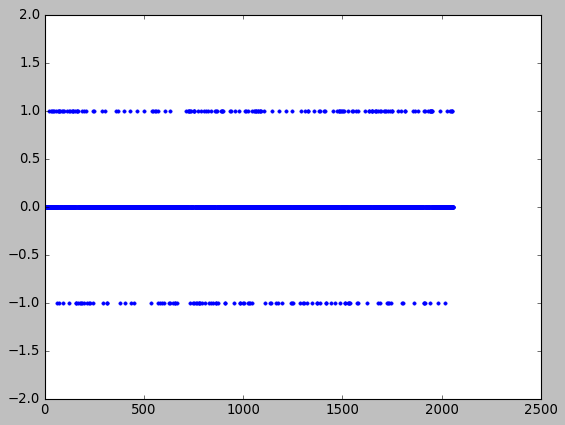

In [38]:
# Differences between target and predictions for test set
plt.plot(np.array(Y_test-pred_binary),'.')
plt.ylim(-2,2)
plt.show()